# Import Lib
Neural machine translation with a Transformer and Keras - https://www.tensorflow.org/text/tutorials/transformer#the_transformer

In [ ]:
#!pip install tensorflow_text

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15,8]
import seaborn as sns
import plotly.graph_objects as go

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Layer, MultiHeadAttention, LayerNormalization, Add, Dense, Dropout, Masking, BatchNormalization
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.math import rsqrt, minimum
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, save_model

In [ ]:
import math
import joblib

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, log_loss

In [ ]:
from tensorflow.keras import initializers

initializer_for_relu = initializers.HeNormal() # For layers with activation function Relu
initializer_for_sigmoid = initializers.GlorotNormal() # For layers with activation function Sigmoid

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

## Import Data

In [ ]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/hobby_project/Data'
data_df = pd.read_csv(path+'/raw_nsepy_inp40_vocab90.csv')
data_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-11,26,23,-5,0,10,0,12,-4,5,...,16,1,4,2,17,-6,16,4,-4,-2
1,26,23,-5,0,10,0,12,-4,5,-10,...,1,4,2,17,-6,16,4,-4,-2,15
2,23,-5,0,10,0,12,-4,5,-10,0,...,4,2,17,-6,16,4,-4,-2,15,23


## Tokenizer

In [ ]:
# Building Vocab
vocab = np.arange(-45,45,1)

In [ ]:
vocab_size = vocab.size
vocab_size

90

In [ ]:
# Creating Tokens
tokens = np.arange(0,91,1)

In [ ]:
val_token_pair = {np.round(s,1):i for i,s in enumerate(vocab)}
print(val_token_pair)

{-45: 0, -44: 1, -43: 2, -42: 3, -41: 4, -40: 5, -39: 6, -38: 7, -37: 8, -36: 9, -35: 10, -34: 11, -33: 12, -32: 13, -31: 14, -30: 15, -29: 16, -28: 17, -27: 18, -26: 19, -25: 20, -24: 21, -23: 22, -22: 23, -21: 24, -20: 25, -19: 26, -18: 27, -17: 28, -16: 29, -15: 30, -14: 31, -13: 32, -12: 33, -11: 34, -10: 35, -9: 36, -8: 37, -7: 38, -6: 39, -5: 40, -4: 41, -3: 42, -2: 43, -1: 44, 0: 45, 1: 46, 2: 47, 3: 48, 4: 49, 5: 50, 6: 51, 7: 52, 8: 53, 9: 54, 10: 55, 11: 56, 12: 57, 13: 58, 14: 59, 15: 60, 16: 61, 17: 62, 18: 63, 19: 64, 20: 65, 21: 66, 22: 67, 23: 68, 24: 69, 25: 70, 26: 71, 27: 72, 28: 73, 29: 74, 30: 75, 31: 76, 32: 77, 33: 78, 34: 79, 35: 80, 36: 81, 37: 82, 38: 83, 39: 84, 40: 85, 41: 86, 42: 87, 43: 88, 44: 89}


In [ ]:
# To return the token of -5
val_token_pair[-5]

40

In [ ]:
val_token_pair[0]

45

In [ ]:
token_val_pair = {i:np.round(s,1) for i,s in enumerate(vocab)}
print(token_val_pair)

{0: -45, 1: -44, 2: -43, 3: -42, 4: -41, 5: -40, 6: -39, 7: -38, 8: -37, 9: -36, 10: -35, 11: -34, 12: -33, 13: -32, 14: -31, 15: -30, 16: -29, 17: -28, 18: -27, 19: -26, 20: -25, 21: -24, 22: -23, 23: -22, 24: -21, 25: -20, 26: -19, 27: -18, 28: -17, 29: -16, 30: -15, 31: -14, 32: -13, 33: -12, 34: -11, 35: -10, 36: -9, 37: -8, 38: -7, 39: -6, 40: -5, 41: -4, 42: -3, 43: -2, 44: -1, 45: 0, 46: 1, 47: 2, 48: 3, 49: 4, 50: 5, 51: 6, 52: 7, 53: 8, 54: 9, 55: 10, 56: 11, 57: 12, 58: 13, 59: 14, 60: 15, 61: 16, 62: 17, 63: 18, 64: 19, 65: 20, 66: 21, 67: 22, 68: 23, 69: 24, 70: 25, 71: 26, 72: 27, 73: 28, 74: 29, 75: 30, 76: 31, 77: 32, 78: 33, 79: 34, 80: 35, 81: 36, 82: 37, 83: 38, 84: 39, 85: 40, 86: 41, 87: 42, 88: 43, 89: 44}


In [ ]:
# To return the value tokenized in 436
token_val_pair[34]

-11

In [ ]:
token_val_pair[0]

-45

In [ ]:
data_df.max().unique()

array([43])

In [ ]:
data_df.min().unique()

array([-43])

## Tokenisation

In [ ]:
# Tokenize the values

#count = 0
tok_matrix = []
for i in data_df.values:
  tok_arr = []
  for j in i:
    tok_arr.append(val_token_pair[j])
  #count+=1
  #print(count)
  tok_matrix.append(tok_arr)

#print(tok_matrix)
data_df_token = pd.DataFrame(tok_matrix)

In [ ]:
data_df_token

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,34,71,68,40,45,55,45,57,41,50,...,61,46,49,47,62,39,61,49,41,43
1,71,68,40,45,55,45,57,41,50,35,...,46,49,47,62,39,61,49,41,43,60
2,68,40,45,55,45,57,41,50,35,45,...,49,47,62,39,61,49,41,43,60,68
3,40,45,55,45,57,41,50,35,45,40,...,47,62,39,61,49,41,43,60,68,65
4,45,55,45,57,41,50,35,45,40,46,...,62,39,61,49,41,43,60,68,65,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72687,50,11,58,42,70,88,72,53,83,42,...,41,29,39,39,33,27,35,39,2,53
72688,11,58,42,70,88,72,53,83,42,29,...,29,39,39,33,27,35,39,2,53,53
72689,58,42,70,88,72,53,83,42,29,2,...,39,39,33,27,35,39,2,53,53,42
72690,42,70,88,72,53,83,42,29,2,2,...,39,33,27,35,39,2,53,53,42,32


## Train Test Split
* Input Length = 36
* Output Length = 4

In [ ]:
inp_len = 36 # Length of the input
out_len = 4 # Length of Output and Context

In [ ]:
test_percentage = 0.0125
train_df, test_df = train_test_split(data_df_token, test_size=test_percentage, random_state=10, shuffle=True)

In [ ]:
print('Train shape',train_df.shape)
print('Test shape',test_df.shape)

Train shape (71783, 40)
Test shape (909, 40)


In [ ]:
val_percentage = 0.2
train_df, val_df = train_test_split(train_df, test_size=val_percentage, random_state=10, shuffle=True)

In [ ]:
print('Train shape',train_df.shape)
print('Validation shape',val_df.shape)
print('Test shape',test_df.shape)

Train shape (57426, 40)
Validation shape (14357, 40)
Test shape (909, 40)


Keras Model.fit training expects (inputs, labels) pairs. The inputs is tokenized sequences. The labels are the same sequences shifted by 1. This shift is so that at each location input sequence, the label in the next token.

In [ ]:
train_df.columns[38:].values

array([38, 39])

In [ ]:
X_train = train_df.drop(columns=train_df.columns[inp_len:].values).values
c_train = train_df.drop(columns=train_df.columns[:inp_len].values).values
y_train = c_train
X_val = val_df.drop(columns=val_df.columns[inp_len:].values).values
c_val = val_df.drop(columns=val_df.columns[:inp_len].values).values
y_val = c_val
X_test = test_df.drop(columns=test_df.columns[inp_len:].values).values
c_test = test_df.drop(columns=test_df.columns[:inp_len].values).values
y_test = c_test

In [ ]:
print('X Train shape',X_train.shape)
print('Context Train shape',c_train.shape)
print('Y Train shape',y_train.shape)
print('X Validation shape',X_val.shape)
print('Context Validation shape',c_val.shape)
print('Y Validation shape',y_val.shape)
print('X Test shape',X_test.shape)
print('Context Test shape',c_test.shape)
print('Y Test shape',y_test.shape)

X Train shape (57426, 36)
Context Train shape (57426, 4)
Y Train shape (57426, 4)
X Validation shape (14357, 36)
Context Validation shape (14357, 4)
Y Validation shape (14357, 4)
X Test shape (909, 36)
Context Test shape (909, 4)
Y Test shape (909, 4)


In [ ]:
X_train[0]

array([51, 50, 44, 46, 52, 56, 44, 49, 46, 53, 39, 44, 42, 54, 42, 42, 39,
       46, 45, 41, 47, 38, 43, 48, 42, 39, 43, 51, 43, 46, 46, 46, 44, 41,
       46, 45])

In [ ]:
c_train[0]

array([37, 44, 42, 42])

In [ ]:
y_train[0]

array([37, 44, 42, 42])

## Add Start and End Tokens
* Start token 1 <br>
* End token 89 <br>
* Padding token 0 <br>

In [ ]:
txt = list(np.arange(1,10,1))
print(txt)
txt.insert(0, 512)
print(txt)
txt.insert(-1,1023)
print(txt)
txt.extend(list(np.zeros(3,int)))
print(txt)

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[512, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[512, 1, 2, 3, 4, 5, 6, 7, 8, 1023, 9]
[512, 1, 2, 3, 4, 5, 6, 7, 8, 1023, 9, 0, 0, 0]


In [ ]:
def Padding(data, pad_type, inp_len, out_len):
  start_tok = 1 # Start Token
  pad_tok = 0 # Padding Token
  end_tok = 89 # End Token

  n_data = list()
  inp_len +=1
  if pad_type == 'all':
    for row in data:
      row = list(row)
      row.insert(0,start_tok)
      row.insert(inp_len,end_tok)
      n_data.append(row)
  if pad_type == 'end':
    for row in data:
      row = list(row)
      row.insert(0,start_tok)
      row.insert(out_len+1,end_tok)
      row.extend([pad_tok for num in range(inp_len - out_len -1 )])
      n_data.append(row)
  if pad_type == 'padding':
    for row in data:
      row = list(row)
      row.insert(out_len,end_tok)
      row.extend([pad_tok for num in range(inp_len - out_len)])
      n_data.append(row)
  return(np.array(n_data))

In [ ]:
#for row in X_train:
#  print(list(row))

In [ ]:
X_train_pad = Padding(X_train, 'all', inp_len, out_len)
print(X_train_pad.shape)
print(X_train_pad[0])
print(X_train.shape)
print(X_train[0])

(57426, 38)
[ 1 51 50 44 46 52 56 44 49 46 53 39 44 42 54 42 42 39 46 45 41 47 38 43
 48 42 39 43 51 43 46 46 46 44 41 46 45 89]
(57426, 36)
[51 50 44 46 52 56 44 49 46 53 39 44 42 54 42 42 39 46 45 41 47 38 43 48
 42 39 43 51 43 46 46 46 44 41 46 45]


In [ ]:
c_train_pad = Padding(c_train, 'end', inp_len, out_len)
print(c_train_pad.shape)
print(c_train_pad[0])
print(c_train.shape)
print(c_train[0])

(57426, 38)
[ 1 37 44 42 42 89  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(57426, 4)
[37 44 42 42]


In [ ]:
y_train_pad = Padding(y_train, 'padding', inp_len, out_len)
print(y_train_pad.shape)
print(y_train_pad[0])
print(y_train.shape)
print(y_train[0])

(57426, 38)
[37 44 42 42 89  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(57426, 4)
[37 44 42 42]


In [ ]:
X_val_pad = Padding(X_val, 'all', inp_len, out_len)
c_val_pad = Padding(c_val, 'end', inp_len, out_len)
y_val_pad = Padding(y_val, 'padding', inp_len, out_len)
X_test_pad = Padding(X_test, 'all', inp_len, out_len)
c_test_pad = Padding(c_test, 'end', inp_len, out_len)
y_test_pad = Padding(y_test, 'padding', inp_len, out_len)

In [ ]:
print('X Train shape',X_train_pad.shape)
print('Context Train shape',c_train_pad.shape)
print('Y Train shape',y_train_pad.shape)
print('X Validation shape',X_val_pad.shape)
print('Context Validation shape',c_val_pad.shape)
print('Y Validation shape',y_val_pad.shape)
print('X Test shape',X_test_pad.shape)
print('Context Test shape',c_test_pad.shape)
print('Y Test shape',y_test_pad.shape)

X Train shape (57426, 38)
Context Train shape (57426, 38)
Y Train shape (57426, 38)
X Validation shape (14357, 38)
Context Validation shape (14357, 38)
Y Validation shape (14357, 38)
X Test shape (909, 38)
Context Test shape (909, 38)
Y Test shape (909, 38)


In [ ]:
MAX_TOKENS = vocab_size
MAX_INP_LEN = X_train_pad.shape[1]

# Model Architecture <br>
* The querys is what you're trying to find.
* The keys what sort of information the dictionary has.
* The value is that information.


In [ ]:
print('Max Tokens =', MAX_TOKENS)
print('Vocabulary =', vocab_size)
print('Max Input Length =', MAX_INP_LEN)

Max Tokens = 90
Vocabulary = 90
Max Input Length = 38


In [ ]:
sample_num_layers = 2 # number of TransformerEncoderLayer layers (Original paper = 6)
sample_d_model = 16 # dimensionality of the embeddings (Original paper = 512)
sample_dff = 32  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
sample_num_heads = 2 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
sample_dropout_rate = 0.2

## The embedding and positional encoding layer
It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

In [ ]:
'''
# Converting the method from numpy to tensorflow

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  positions = tf.experimental.numpy.arange(length, dtype=tf.float32)[:, tf.newaxis]
  depths = tf.experimental.numpy.arange(depth, dtype=tf.float32)[tf.newaxis, :]

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)
'''

'\n# Converting the method from numpy to tensorflow\n\ndef positional_encoding(length, depth):\n  depth = depth/2\n\n  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)\n  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)\n\n  positions = tf.experimental.numpy.arange(length, dtype=tf.float32)[:, tf.newaxis]\n  depths = tf.experimental.numpy.arange(depth, dtype=tf.float32)[tf.newaxis, :]\n\n  angle_rates = 1 / (10000**depths)         # (1, depth)\n  angle_rads = positions * angle_rates      # (pos, depth)\n\n  pos_encoding = np.concatenate(\n      [np.sin(angle_rads), np.cos(angle_rads)],\n      axis=-1)\n\n  return tf.cast(pos_encoding, dtype=tf.float32)\n'

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = tf.experimental.numpy.arange(length, dtype=tf.float32)[:, tf.newaxis]
  depths = tf.experimental.numpy.arange(depth, dtype=tf.float32)[tf.newaxis, :]

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = tf.concat(
    [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
    axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class PositionalEmbedding(Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=MAX_INP_LEN, depth=d_model)
    self.token_embedding = Embedding(vocab_size,d_model,mask_zero=True)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def build(self, input_shape):
    # Define weights
    self.kernel = self.add_weight(
        shape=((self.vocab_size, self.d_model)),
        #initializer='uniform',
        initializer=initializer_for_relu,
        trainable=True
    )

  def call(self, x, mask=None):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

In [ ]:
# Create an Embedding Object
embed_inp = PositionalEmbedding(vocab_size=vocab_size, d_model=sample_d_model) # 8-dimensional (for small datasets)
embed_inp.build(X_train_pad[:3])
# Calling the function
inp_emb = embed_inp(X_train_pad[:3])
inp_emb_mask = inp_emb._keras_mask
print(inp_emb.shape)
print(inp_emb_mask.shape)

(3, 38, 16)
(3, 38)


In [ ]:
# Testing the Embedding Object Function
inp_emb[0,:,0]

<tf.Tensor: shape=(38,), dtype=float32, numpy=
array([-0.11543627,  0.9749261 ,  0.9824265 , -0.04538675, -0.9256519 ,
       -0.79091483, -0.47465402,  0.47047985,  0.95425403,  0.24326909,
       -0.59978664, -0.89000756, -0.7230797 ,  0.31444776,  1.0988883 ,
        0.5445686 , -0.39362264, -0.8514148 , -0.91983664,  0.00779061,
        1.037036  ,  0.9167637 , -0.14886104, -0.8378812 , -1.0065    ,
       -0.23807104,  0.8725411 ,  0.9647151 ,  0.40436095, -0.6552947 ,
       -1.156881  , -0.57288706,  0.38257733,  0.8134051 ,  0.65317345,
       -0.59703207, -1.1338655 , -0.7691283 ], dtype=float32)>

In [ ]:
inp_emb_mask[0]

<tf.Tensor: shape=(38,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])>

In [ ]:
# Calling the function
c_emb = embed_inp(c_train_pad[:3])
# To check if masking is enabled to the input
c_emb_mask = c_emb._keras_mask
print(c_emb.shape)
print(c_emb_mask.shape)

(3, 38, 16)
(3, 38)


In [ ]:
print(c_emb._keras_mask[0])
print(c_emb[0,:,0])

tf.Tensor(
[ True  True  True  True  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False], shape=(38,), dtype=bool)
tf.Tensor(
[-0.11543627  0.6549343   0.72279066  0.03540072 -0.86252177 -1.0845145
 -0.41961116  0.5167909   0.8491626   0.27192283 -0.68421674 -1.1401858
 -0.6767686   0.27997136  0.8504117   0.5100922  -0.42809898 -1.1015931
 -0.8911829   0.00968155  0.7727496   0.69645995 -0.14904696 -0.98641604
 -1.045774   -0.27254742  0.6223628   0.8161803   0.13071014 -0.80382955
 -1.1282272  -0.5442333   0.41123104  0.8597162   0.38888705 -0.5683783
 -1.1319745  -0.7837338 ], shape=(38,), dtype=float32)


In [ ]:
# Calling the function
y_emb = embed_inp(y_train_pad[:3])
print(y_emb.shape)

# To check if masking is enabled to the input
y_emb_mask = y_emb._keras_mask
print(y_emb_mask.shape)
y_emb_mask[2]

(3, 38, 16)
(3, 38)


<tf.Tensor: shape=(38,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])>

(38, 16)


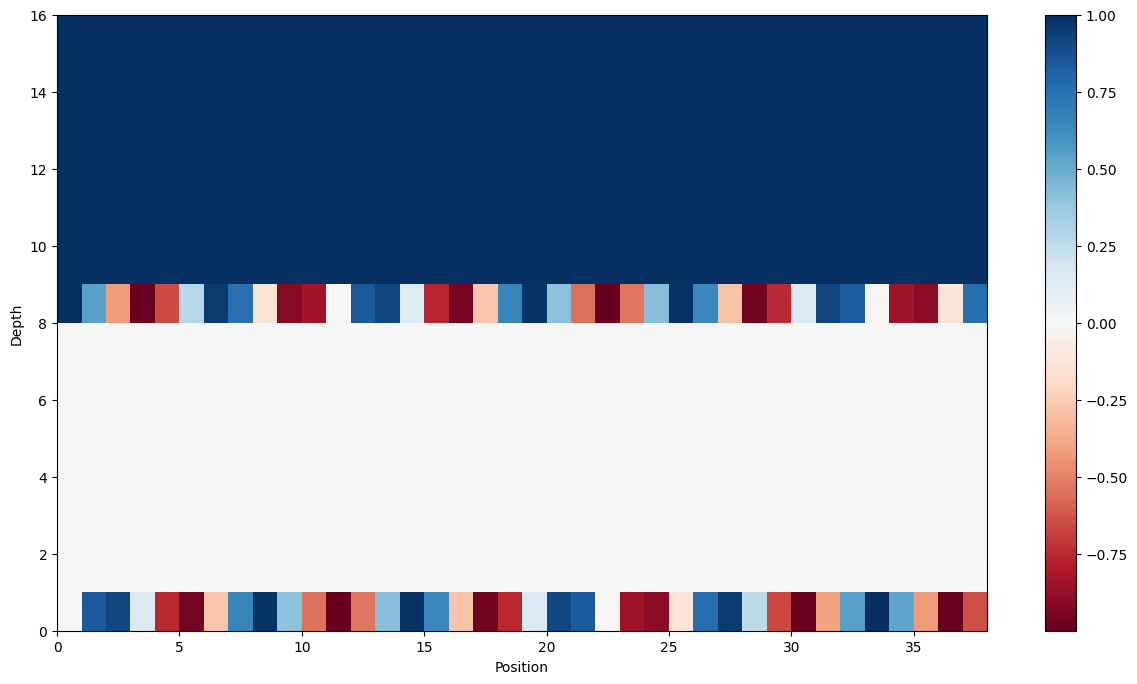

In [ ]:
pos_encoding = positional_encoding(length=MAX_INP_LEN, depth=sample_d_model)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Custom Attention Block

In [ ]:
class BaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()
    #self.mask = Masking()

In [ ]:
class CrossAttention(BaseAttention):

  def build(self, input_shape):
    ## Define weights
      self.kernel = self.add_weight(
          shape=(input_shape),
          #initializer='uniform',
          initializer=initializer_for_relu,
          trainable=True)
      super(CrossAttention, self).build(input_shape)

  def call(self, key_val, query_context):
    attn_output, attn_scores = self.mha(
        query=query_context,  # The querys is what you're trying to find.
        key=key_val,  # The keys what sort of information the dictionary has.
        value=key_val, # The value is that information.
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([key_val,attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
# Text the class
sample_ca = CrossAttention(num_heads=sample_num_heads, key_dim=sample_d_model)

In [ ]:
inp_emb._keras_mask.shape

TensorShape([3, 38])

In [ ]:
inp_emb._keras_mask[:, tf.newaxis].shape

TensorShape([3, 1, 38])

In [ ]:
print("input shape =",inp_emb.shape)
crossatt_out = sample_ca(key_val=inp_emb,query_context=c_emb)
print("Cross attention shape =",crossatt_out.shape)

input shape = (3, 38, 16)
Cross attention shape = (3, 38, 16)


In [ ]:
crossatt_out[0][0]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([-1.7607831 , -0.07344252, -1.0619646 , -1.2106574 , -0.73261726,
       -0.96829605, -0.16857684, -1.030951  ,  0.5537297 ,  1.339628  ,
        1.69308   ,  0.51649135,  0.9227317 ,  0.73870164,  0.24369377,
        0.99923366], dtype=float32)>

In [ ]:
sample_ca.last_attn_scores[1,0:4,1,:]

<tf.Tensor: shape=(2, 38), dtype=float32, numpy=
array([[0.02707257, 0.02691302, 0.02565268, 0.02565394, 0.02590459,
        0.02643725, 0.0272908 , 0.02725272, 0.02585973, 0.02528788,
        0.02556892, 0.02635453, 0.02747433, 0.0274657 , 0.02668075,
        0.02522808, 0.02563142, 0.02597099, 0.02696085, 0.02699814,
        0.02690285, 0.02557506, 0.02520021, 0.02594678, 0.02695598,
        0.02698989, 0.02684175, 0.02562907, 0.02541558, 0.02552065,
        0.02618452, 0.02699826, 0.02716904, 0.0265877 , 0.02578031,
        0.02547517, 0.02633338, 0.02683501],
       [0.02598676, 0.02680422, 0.02621667, 0.02684726, 0.02610794,
        0.02598345, 0.02686941, 0.0268606 , 0.02706128, 0.0256677 ,
        0.0258963 , 0.02564812, 0.0264462 , 0.02722944, 0.02717566,
        0.02630249, 0.02598358, 0.02496155, 0.02608506, 0.0268396 ,
        0.02694892, 0.02600752, 0.02630509, 0.02570848, 0.0257714 ,
        0.02649025, 0.02674893, 0.02672072, 0.02608786, 0.02504287,
        0.02547354, 0.

## The global self-attention layer

In [ ]:
class GlobalSelfAttention(BaseAttention):

  def build(self, input_shape):
    ## Define weights
      self.kernel = self.add_weight(
          shape=(input_shape),
          #initializer='uniform',
          initializer=initializer_for_relu,
          trainable=True)
      super(GlobalSelfAttention, self).build(input_shape)

  def call(self, key_val):
    attn_output = self.mha(
        query=key_val,  # The querys is what you're trying to find.
        key=key_val,  # The keys what sort of information the dictionary has.
        value=key_val, # The value is that information.
        )
    x = self.add([key_val, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=sample_num_heads, key_dim=sample_d_model)

print(inp_emb.shape)
print(sample_gsa(inp_emb).shape)

(3, 38, 16)
(3, 38, 16)


In [ ]:
globalatt_out = sample_gsa(inp_emb)

In [ ]:
globalatt_out[0][0]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([-1.1391218 , -0.19702774, -1.8220725 , -0.89510226, -0.9120794 ,
       -1.0776954 , -0.7705302 , -0.37310326,  1.0043488 ,  0.697986  ,
        0.77297187,  0.3562628 ,  1.4997724 ,  0.51719403,  0.79785955,
        1.5403367 ], dtype=float32)>

In [ ]:
globalatt_out._keras_mask[0][0]

<tf.Tensor: shape=(), dtype=bool, numpy=True>

## Masked Attention Layer <br>
Causal Self Attention

Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this efficient, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".<br>
The causal mask ensures that each location only has access to the locations that come before it:

In [ ]:
class CausalSelfAttention(BaseAttention):

  def build(self, input_shape):
    ## Define weights
      self.kernel = self.add_weight(
          shape=(input_shape),
          #initializer='uniform',
          initializer=initializer_for_relu,
          trainable=True)
      super(CausalSelfAttention, self).build(input_shape)

  def call(self, context):#, num_heads):
    ##x = self.mask(x)
    ## Reshape for compatibility of Mask with attention layer
    #expanded_mask = context._keras_mask[:, tf.newaxis, tf.newaxis, :]  # Shape: (batch_size, 1, 1, seq_length)
    ## Now expand to (batch_size, num_heads, 1, L)
    #expanded_mask = tf.repeat(expanded_mask, num_heads, axis=1) # Shape: (batch_size, num_heads, 1, seq_length)

    # Now expand to (batch_size, seq_length, seq_length)
    context_mask = tf.expand_dims(context._keras_mask, axis=2) # Shape: (batch_size, seq_length, seq_length)

    attn_output, attn_scores = self.mha(
        query=context, # The querys is what you're trying to find.
        value=context, # The keys what sort of information the dictionary has.
        key=context, # The value is that information.
        use_causal_mask = True, # causal_mask is used to appropriately mask when computing the attention scores
        attention_mask = context_mask, # used to ignoring padding tokens
        return_attention_scores=True
        )
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    context = self.add([context, attn_output])
    context = self.layernorm(context)
    return context

In [ ]:
print(c_emb.shape)
print(c_emb._keras_mask[:, tf.newaxis, tf.newaxis, :].shape)
# Now expand to (batch_size, num_heads, 1, L)
padding_mask = tf.repeat(c_emb._keras_mask[:, tf.newaxis, tf.newaxis, :], sample_num_heads, axis=1)  # Shape: (batch_size, num_heads, 1, seq_length)
print(padding_mask.shape)

(3, 38, 16)
(3, 1, 1, 38)
(3, 2, 1, 38)


In [ ]:
sample_csa = CausalSelfAttention(num_heads=sample_num_heads, key_dim=sample_d_model)
selfatt_out = sample_csa(context=c_emb)
#selfatt_out = sample_csa(c_emb)

print(c_emb.shape)
print(sample_csa.last_attn_scores.shape)
print(selfatt_out.shape)

(3, 38, 16)
(3, 2, 38, 38)
(3, 38, 16)


In [ ]:
sample_csa.last_attn_scores[1,1:3,1,:]

<tf.Tensor: shape=(1, 38), dtype=float32, numpy=
array([[0.48936448, 0.51063544, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]], dtype=float32)>

In [ ]:
selfatt_out[0,:,0]

<tf.Tensor: shape=(38,), dtype=float32, numpy=
array([-0.82926124,  0.07166466,  0.14668256, -0.72203493, -1.7977185 ,
       -1.8918138 , -1.2654146 , -0.11250886,  0.41146898, -0.2798488 ,
       -1.4157705 , -1.970456  , -1.5408185 , -0.4295108 ,  0.38919157,
        0.01124722, -1.1166154 , -1.9101834 , -1.757122  , -0.7687296 ,
        0.25937712,  0.2386198 , -0.7868962 , -1.7693092 , -1.9024684 ,
       -1.1008897 ,  0.03593874,  0.37859696, -0.45136636, -1.5553403 ,
       -1.9690521 , -1.4013332 , -0.25659463,  0.41466886, -0.13736495,
       -1.2811167 , -1.9529234 , -1.650807  ], dtype=float32)>

In [ ]:
#out1 = sample_csa(embed_inp(X_train_pad[:, :3]))
#out2 = sample_csa(embed_inp(X_train_pad))[:, :3]

#tf.reduce_max(abs(out1 - out2)).numpy()

## Feed Forward Network Layer

In [ ]:
class FeedForward(Layer):
  # dff - dence feed forward neurons
  # d_model - input shape
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = Sequential([
      Dense(dff, activation='relu',kernel_initializer=initializer_for_relu),
      Dropout(dropout_rate),
      Dense(d_model, activation='relu',kernel_initializer=initializer_for_relu),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [ ]:
sample_ffn = FeedForward(sample_d_model, sample_dff)
sample_ffn_out = sample_ffn(inp_emb)
print(inp_emb.shape)
print(sample_ffn_out.shape)

(3, 38, 16)
(3, 38, 16)


In [ ]:
sample_ffn_out[0,0,:8]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-1.2550983 , -0.7521174 , -1.3012961 , -1.2282058 , -0.9749842 ,
       -0.51788384,  0.6463238 , -0.8086473 ], dtype=float32)>

## Complete Encoder Layer

In [ ]:
class EncoderLayer(Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, key_val):
    x = self.self_attention(key_val)
    x = self.ffn(x)
    return x

In [ ]:
class Encoder(Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
      for _ in range(num_layers)]

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.dropout = Dropout(dropout_rate)

  def call(self, key_val):
    # `x` is token-IDs
    x = self.pos_embedding(key_val)
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

In [ ]:
# Testing the encoder

# Instantiate the encoder.
sample_encoder = Encoder(num_layers=sample_num_layers,
                         d_model=sample_d_model,
                         num_heads=sample_num_heads,
                         dff=sample_dff,
                         vocab_size=vocab_size)

In [ ]:
sample_encoder_output = sample_encoder(X_train_pad[:3], training=False)
# Print the shape.
print(X_train_pad[:3].shape)
print(sample_encoder_output.shape)

(3, 38)
(3, 38, 16)


In [ ]:
sample_encoder_output[0,0,:]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([-1.2335032 ,  0.47338206,  0.10808869, -1.090117  , -0.8709698 ,
        0.17632659,  1.8725681 , -2.2293856 ,  0.75717187, -0.7912052 ,
        0.01602593,  0.30467284,  0.81720674,  1.3127935 ,  0.08423539,
        0.29270953], dtype=float32)>

## Complete Decoder Layer

Each DecoderLayer containing a CausalSelfAttention, a CrossAttention, and a FeedForward layer:

In [ ]:
class DecoderLayer(Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_att = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate
    )

    self.cross_att = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate
    )

    self.ffn = FeedForward(d_model, dff)

  def call(self, key_val, query_context):
    self_att_out = self.causal_self_att(context=query_context)
    cross_att_out = self.cross_att(key_val=key_val, query_context=self_att_out)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_att.last_attn_scores

    fnn_out = self.ffn(cross_att_out)

    return fnn_out


In [ ]:
# Testing decoder layer

sample_decoder_layer = DecoderLayer(d_model=sample_d_model, num_heads=sample_num_heads, dff=sample_dff)

sample_decoder_layer_output = sample_decoder_layer(
    key_val=inp_emb, query_context=c_emb)

In [ ]:
sample_decoder_layer_output[0,0,:]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([-8.9513218e-01, -3.8081300e-01, -2.0723507e+00, -1.3028677e+00,
       -8.8252991e-01, -9.6713334e-01,  1.9478649e-03, -6.3515055e-01,
        9.0288860e-01,  3.9467484e-01,  6.4307553e-01,  8.7632638e-01,
        9.8065656e-01,  1.1943096e+00,  8.5497457e-01,  1.2871233e+00],
      dtype=float32)>

In [ ]:
print(inp_emb.shape)
print(sample_decoder_layer_output.shape)

(3, 38, 16)
(3, 38, 16)


In [ ]:
sample_decoder_layer.last_attn_scores[0,0,0,:]

<tf.Tensor: shape=(38,), dtype=float32, numpy=
array([0.02695577, 0.02685937, 0.0258749 , 0.02614062, 0.02585389,
       0.02645871, 0.02684507, 0.02669191, 0.0258313 , 0.0255745 ,
       0.0259963 , 0.02662086, 0.02692548, 0.02672737, 0.0263357 ,
       0.02608125, 0.02616312, 0.02651194, 0.02632685, 0.02635649,
       0.0265047 , 0.02589891, 0.02595166, 0.0263181 , 0.02688861,
       0.0268512 , 0.02656404, 0.02610978, 0.026402  , 0.02621013,
       0.02618245, 0.02636254, 0.02617634, 0.02635442, 0.02611139,
       0.02571243, 0.02613931, 0.02613056], dtype=float32)>

In [ ]:
class Decoder(Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.decoder_layer = [DecoderLayer(
      d_model=d_model,
      num_heads=num_heads,
      dff=dff,
      dropout_rate=dropout_rate
    ) for _ in range(num_layers)]

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)

    self.dropout = Dropout(rate=dropout_rate)

    self.last_attn_scores = None

    self.d_model = d_model
    self.num_layers = num_layers

  def call(self, key_val, query_context):
    query_context = self.pos_embedding(query_context)

    query_context = self.dropout(query_context)

    for i in range(self.num_layers):
      x  = self.decoder_layer[i](key_val=key_val, query_context=query_context)

    self.last_attn_scores = self.decoder_layer[-1].last_attn_scores

    return x

In [ ]:
# Test the decoder

# Instantiate the decoder.
sample_decoder = Decoder(num_layers=sample_num_layers,
                         d_model=sample_d_model,
                         num_heads=sample_num_heads,
                         dff=sample_dff,
                         vocab_size=vocab_size)

sample_decoder_output = sample_decoder(
    key_val=inp_emb,
    query_context=c_train_pad[:3])

In [ ]:
sample_decoder_output[0,:,0]

<tf.Tensor: shape=(38,), dtype=float32, numpy=
array([-1.2936898 ,  1.0734719 ,  0.5942105 , -0.93717265, -2.239616  ,
       -2.453277  , -1.691416  , -0.27657416,  0.46953446, -0.51701474,
       -1.7868917 , -2.424981  , -2.0149393 , -0.7046727 ,  0.968245  ,
       -0.17729798, -1.62275   , -2.3661828 , -2.2501001 , -1.0104835 ,
        0.7363564 ,  0.5177254 , -1.1699185 , -2.4737072 , -2.5234854 ,
       -1.668138  ,  0.27724737,  0.5899989 , -0.0749635 , -2.1439183 ,
       -2.5526843 , -1.8498812 , -0.44141755,  0.40535092,  0.00803784,
       -1.7500632 , -2.7326684 , -2.218575  ], dtype=float32)>

In [ ]:
print(c_train_pad[:3].shape)
print(inp_emb.shape)
print(sample_decoder_output.shape)

(3, 38)
(3, 38, 16)
(3, 38, 16)


## Final Neural Network Layer

In [ ]:
class FinalFeedForward(Layer):
  # dff - dence feed forward neurons
  # d_model - input shape
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = Sequential([
      Dense(dff, activation='relu',kernel_initializer=initializer_for_relu),
      Dense(d_model, activation='relu',kernel_initializer=initializer_for_relu),
      Dropout(dropout_rate),
      BatchNormalization()
    ])

  def call(self, x):
    x = self.seq(x)
    return x

In [ ]:
# Testing the Final feed Forward layer
sample_ffl_layer = FinalFeedForward(d_model=sample_d_model, dff=sample_dff)
sample_ffl_layer_output = sample_ffl_layer(sample_decoder_output)

print(sample_ffl_layer_output.shape)

(3, 38, 16)


## Transformer

In [ ]:
class Transformer(Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_feed_forward_layer = FinalFeedForward(d_model=d_model,  dff=dff)

    self.final_layer = Dense(target_vocab_size, kernel_initializer=initializer_for_sigmoid)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    key_val, query_context  = inputs

    enc_out = self.encoder(key_val=key_val)  # (batch_size, context_len, d_model)

    dec_out = self.decoder(key_val=enc_out, query_context=query_context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    ffl_out = self.final_feed_forward_layer(dec_out) # (batch_size, target_len, d_model)

    logits = self.final_layer(ffl_out)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

## Custom Learning Rate

In [ ]:
class CustomSchedule(LearningRateSchedule):
  def __init__(self, d_model, warmup_steps):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return rsqrt(self.d_model) * minimum(arg1, arg2)

In [ ]:
sample_warmup_steps = 10
sample_learning_rate = CustomSchedule(1024, sample_warmup_steps)

sample_optimizer = Adam(sample_learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-8)

Text(0.5, 0, 'Train Step')

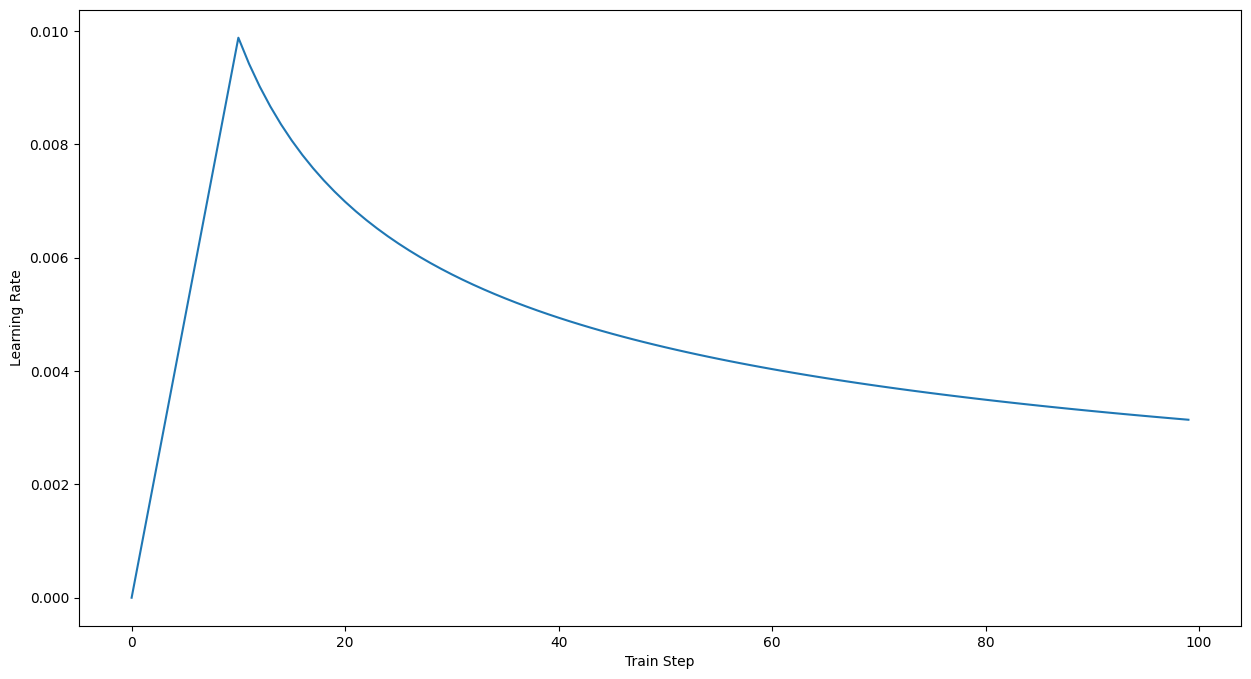

In [ ]:
# Check the learning Rate
plt.plot(sample_learning_rate(tf.range(100, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Set up the loss and metrics

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
'''
i = 7
j = 1
sample_label = y_test_pad[i,j]
print('smple y actuals = ',sample_label)
sample_pred = predictions_reconstructed_model[i,j]
print('smple y pred = ',sample_pred)
sample_loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='sum_over_batch_size')
sample_loss = sample_loss_object(sample_label, sample_pred)
print('Sample loss = ',sample_loss)
sample_masked_loss = masked_loss(sample_label, sample_pred)
print('Sample masked loss = ',sample_masked_loss)
#print('Sample masked accuracy = ', masked_accuracy(sample_label, sample_pred))
'''

"\ni = 7\nj = 1\nsample_label = y_test_pad[i,j]\nprint('smple y actuals = ',sample_label)\nsample_pred = predictions_reconstructed_model[i,j]\nprint('smple y pred = ',sample_pred)\nsample_loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='sum_over_batch_size')\nsample_loss = sample_loss_object(sample_label, sample_pred)\nprint('Sample loss = ',sample_loss)\nsample_masked_loss = masked_loss(sample_label, sample_pred)\nprint('Sample masked loss = ',sample_masked_loss)\n#print('Sample masked accuracy = ', masked_accuracy(sample_label, sample_pred))\n"

# Model 1

## Model building

In [ ]:
#Define a model with Transformer layer
tf.keras.backend.clear_session()
#model = tf.keras.Sequential()

In [ ]:
num_layers = 6 # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 32 # dimensionality of the embeddings (Original paper = 512)
dff = 128  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 6 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.2
warmup_steps = 200 # Number of Train steps the Lerning Rate must be high

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size,
    target_vocab_size=vocab_size,
    dropout_rate=dropout_rate)

In [ ]:
output = transformer((X_train_pad[:3], c_train_pad[:3]))

print(X_train_pad[:3].shape)
print(output.shape)

(3, 38)
(3, 38, 90)


In [ ]:
attn_scores = transformer.decoder.decoder_layer[-1].last_attn_scores
print(attn_scores.shape)

(3, 6, 38, 38)


In [ ]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │         403,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ final_feed_forward                   │ ?                           │           8,480 │
│ (FinalFeedForward)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (3, 38, 90)                 │           2,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 644,090 (2.46 MB)

 Trainable params: 644,026 (2.46 MB)

 Non-trainable params: 64 (256.00 B)

## Training

In [ ]:
(d_model)**3

32768

In [ ]:
learning_rate = CustomSchedule(1024, warmup_steps)
optimizer = Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
path_model = '/content/drive/MyDrive/hobby_project/Models'
checkpoint_filepath = (path_model+'/4SF_nsepy_Model_inp36_out4_vocab90.weights.h5')
print(checkpoint_filepath)

/content/drive/MyDrive/hobby_project/Models/4SF_nsepy_Model_inp36_out4_vocab90.weights.h5


In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    #monitor='val_loss',
    monitor='loss',
    mode='min',
    save_best_only=True)

early_stopping = EarlyStopping(#monitor="val_loss",
                               monitor='loss',
                               patience=10, mode="min",
                               restore_best_weights=True)

In [ ]:
transformer.fit((X_train_pad,c_train_pad),y_train_pad,
                epochs=10, batch_size=32,
                validation_data=[(X_val_pad,c_val_pad),y_val_pad],
                callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 111s 34ms/step - loss: 927.1342 - masked_accuracy: 0.1976 - val_loss: 429.4727 - val_masked_accuracy: 0.2712
Epoch 2/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 429.0432 - masked_accuracy: 0.2703 - val_loss: 427.1935 - val_masked_accuracy: 0.2726
Epoch 3/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 427.0343 - masked_accuracy: 0.2710 - val_loss: 426.7922 - val_masked_accuracy: 0.2729
Epoch 4/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 427.6974 - masked_accuracy: 0.2723 - val_loss: 426.7213 - val_masked_accuracy: 0.2723
Epoch 5/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 427.3079 - masked_accuracy: 0.2723 - val_loss: 426.3124 - val_masked_accuracy: 0.2730
Epoch 6/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 426.9802 - masked_accuracy: 0.2719 - val_loss: 426.3286 - val_masked_accuracy: 0.2716
Epoch 7/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 425.8360 - masked_accuracy: 0.2732 

In [ ]:
transformer.fit((X_train_pad,c_train_pad),y_train_pad,
                initial_epoch=10,epochs=20, batch_size=32,
                validation_data=[(X_val_pad,c_val_pad),y_val_pad],
                callbacks=[model_checkpoint_callback, early_stopping])

Epoch 11/20
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 425.8008 - masked_accuracy: 0.2716 - val_loss: 426.2684 - val_masked_accuracy: 0.2728
Epoch 12/20
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 424.9922 - masked_accuracy: 0.2731 - val_loss: 426.1682 - val_masked_accuracy: 0.2726
Epoch 13/20
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 425.5728 - masked_accuracy: 0.2731 - val_loss: 426.0367 - val_masked_accuracy: 0.2729
Epoch 14/20
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 425.5671 - masked_accuracy: 0.2727 - val_loss: 426.0507 - val_masked_accuracy: 0.2727
Epoch 15/20
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 425.9691 - masked_accuracy: 0.2718 - val_loss: 426.0665 - val_masked_accuracy: 0.2730
Epoch 16/20
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 425.2780 - masked_accuracy: 0.2736 - val_loss: 425.9850 - val_masked_accuracy: 0.2729
Epoch 17/20
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 424.9336 - masked_accuracy: 0

In [ ]:
transformer.fit((X_train_pad,c_train_pad),y_train_pad,
                initial_epoch=20,epochs=50, batch_size=32,
                validation_data=[(X_val_pad,c_val_pad),y_val_pad],
                callbacks=[model_checkpoint_callback, early_stopping])

Epoch 21/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 424.9302 - masked_accuracy: 0.2727 - val_loss: 425.7777 - val_masked_accuracy: 0.2730
Epoch 22/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 425.4472 - masked_accuracy: 0.2721 - val_loss: 425.7630 - val_masked_accuracy: 0.2738
Epoch 23/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 424.9764 - masked_accuracy: 0.2735 - val_loss: 425.7985 - val_masked_accuracy: 0.2735
Epoch 24/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 424.8213 - masked_accuracy: 0.2728 - val_loss: 425.6668 - val_masked_accuracy: 0.2744
Epoch 25/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 424.8719 - masked_accuracy: 0.2729 - val_loss: 425.8588 - val_masked_accuracy: 0.2736
Epoch 26/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 424.5907 - masked_accuracy: 0.2739 - val_loss: 425.7637 - val_masked_accuracy: 0.2737
Epoch 27/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 423.6523 - masked_accuracy: 0

In [ ]:
transformer.fit((X_train_pad,c_train_pad),y_train_pad,
                initial_epoch=50,epochs=100, batch_size=32,
                validation_data=[(X_val_pad,c_val_pad),y_val_pad],
                callbacks=[model_checkpoint_callback, early_stopping])

Epoch 51/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 420.1987 - masked_accuracy: 0.2777 - val_loss: 426.5074 - val_masked_accuracy: 0.2740
Epoch 52/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 419.6879 - masked_accuracy: 0.2785 - val_loss: 426.5497 - val_masked_accuracy: 0.2726
Epoch 53/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 419.4444 - masked_accuracy: 0.2777 - val_loss: 427.3948 - val_masked_accuracy: 0.2739
Epoch 54/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 419.5056 - masked_accuracy: 0.2768 - val_loss: 427.1754 - val_masked_accuracy: 0.2736
Epoch 55/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 419.5364 - masked_accuracy: 0.2774 - val_loss: 427.0730 - val_masked_accuracy: 0.2732
Epoch 56/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 418.8340 - masked_accuracy: 0.2787 - val_loss: 426.7111 - val_masked_accuracy: 0.2726
Epoch 57/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 418.3975 - masked_accu

In [ ]:
transformer.fit((X_train_pad,c_train_pad),y_train_pad,
                initial_epoch=100,epochs=200, batch_size=32,
                validation_data=[(X_val_pad,c_val_pad),y_val_pad],
                callbacks=[model_checkpoint_callback, early_stopping])

Epoch 101/200
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 406.7267 - masked_accuracy: 0.2900 - val_loss: 435.9477 - val_masked_accuracy: 0.2724
Epoch 102/200
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 406.8978 - masked_accuracy: 0.2894 - val_loss: 435.1786 - val_masked_accuracy: 0.2725
Epoch 103/200
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 406.0583 - masked_accuracy: 0.2908 - val_loss: 435.5941 - val_masked_accuracy: 0.2728
Epoch 104/200
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 406.4793 - masked_accuracy: 0.2902 - val_loss: 434.9585 - val_masked_accuracy: 0.2722
Epoch 105/200
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 405.9665 - masked_accuracy: 0.2911 - val_loss: 436.6008 - val_masked_accuracy: 0.2730
Epoch 106/200
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 405.9261 - masked_accuracy: 0.2910 - val_loss: 437.8860 - val_masked_accuracy: 0.2736
Epoch 107/200
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 406.0620 - mask

In [ ]:
transformer.fit((X_train_pad,c_train_pad),y_train_pad,
                initial_epoch=200,epochs=300, batch_size=32,
                validation_data=[(X_val_pad,c_val_pad),y_val_pad],
                callbacks=[model_checkpoint_callback, early_stopping])

Epoch 201/300
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 386.6200 - masked_accuracy: 0.3118 - val_loss: 462.6815 - val_masked_accuracy: 0.2697
Epoch 202/300
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - loss: 386.8829 - masked_accuracy: 0.3117 - val_loss: 466.8491 - val_masked_accuracy: 0.2699
Epoch 203/300
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - loss: 386.8032 - masked_accuracy: 0.3118 - val_loss: 466.1640 - val_masked_accuracy: 0.2693
Epoch 204/300
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 385.9298 - masked_accuracy: 0.3118 - val_loss: 463.6392 - val_masked_accuracy: 0.2684
Epoch 205/300
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 386.3636 - masked_accuracy: 0.3120 - val_loss: 466.2201 - val_masked_accuracy: 0.2689
Epoch 206/300
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 385.4874 - masked_accuracy: 0.3123 - val_loss: 467.1569 - val_masked_accuracy: 0.2693
Epoch 207/300
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 386.2710 - mask

## Prediction - from Transformer

In [ ]:
predictions = transformer((X_test_pad,c_test_pad), training=False)

In [ ]:
predictions.shape

TensorShape([909, 38, 90])

In [ ]:
predictions[0]

<tf.Tensor: shape=(38, 90), dtype=float32, numpy=
array([[-2.0515194e+01, -3.0085396e+01, -1.3424065e+00, ...,
        -4.3168817e+00, -2.0244193e+00, -1.6582821e+01],
       [-1.8943426e+01, -2.2986374e+01, -8.0058527e-01, ...,
        -2.2788110e+00,  9.3850446e-01, -1.3933589e+01],
       [-8.2040321e+01, -1.8160117e+02, -9.4041061e+01, ...,
        -1.4978018e+02, -1.0032383e+02, -6.1733860e+01],
       ...,
       [-2.2056545e+03, -5.9004971e+03, -3.9031008e+03, ...,
        -6.9983379e+03, -4.8890239e+03, -2.3775076e+03],
       [-2.2892700e+03, -6.1306289e+03, -4.0577092e+03, ...,
        -7.2680825e+03, -5.0772896e+03, -2.4807239e+03],
       [-2.2164255e+03, -5.9359541e+03, -3.9327632e+03, ...,
        -7.0234922e+03, -4.8979707e+03, -2.4295276e+03]], dtype=float32)>

In [ ]:
predictions_val = np.argmax(predictions, axis=2)
predictions_val.shape

(909, 38)

In [ ]:
i = 543
print('Predictions = \n',predictions_val[i])
print('Actuals = \n',y_test_pad[i])

Predictions = 
 [49 18 49 49 89  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Actuals = 
 [37 42 39 50 89  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


### Validating the results

#### Pred 0

In [ ]:
y_pred_0 = predictions_val[:,0]
y_test_0 = y_test[:,0]
print(y_pred_0.shape)
print(y_test_0.shape)

(909,)
(909,)


In [ ]:
print('Accuracy Score',accuracy_score(y_test_0, y_pred_0))
print('Classification report \n',classification_report(y_test_0, y_pred_0))

Accuracy Score 0.10891089108910891
Classification report 
               precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         3
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         4
          25       0.00      0.00      0.00         2
          26       0.0

In [ ]:
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),
                    open=y_pred_0,
                    high=y_pred_0,
                    low=y_test_0,
                    close=y_test_0
                              )])
fig.show()

#### Pred 1

In [ ]:
y_pred_1 = predictions_val[:,1]
y_test_1 = y_test[:,1]
print(y_pred_1.shape)
print(y_test_1.shape)

(909,)
(909,)


In [ ]:
print('Accuracy Score',accuracy_score(y_test_1, y_pred_1))
print('Classification report \n',classification_report(y_test_1, y_pred_1))

Accuracy Score 0.0924092409240924
Classification report 
               precision    recall  f1-score   support

           2       0.33      1.00      0.50         1
           3       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         4
          22       0.00      0.00      0.00         1
          23       0.00      0.00      0.00         2
          24       0.00

In [ ]:
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),
                    open=y_pred_1,
                    high=y_pred_1,
                    low=y_test_1,
                    close=y_test_1
                              )])
fig.show()

#### Pred 2

In [ ]:
y_pred_2 = predictions_val[:,2]
y_test_2 = y_test[:,2]
print(y_pred_1.shape)
print(y_test_1.shape)

(909,)
(909,)


In [ ]:
print('Accuracy Score',accuracy_score(y_test_2, y_pred_2))
print('Classification report \n',classification_report(y_test_2, y_pred_2))

Accuracy Score 0.1078107810781078
Classification report 
               precision    recall  f1-score   support

           2       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         2
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1
          23       0.00      0.00      0.00         3
          25       0.00      0.00      0.00         0
          26       0.00      0.00      0.00         0
          27       0.00      0.00      0.00         3
          28       0.00      0.00      0.00         7
          29       0.00

In [ ]:
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),
                    open=y_pred_2,
                    high=y_pred_2,
                    low=y_test_2,
                    close=y_test_2
                              )])
fig.show()

#### Pred 3

In [ ]:
y_pred_3 = predictions_val[:,3]
y_test_3 = y_test[:,3]
print(y_pred_3.shape)
print(y_test_3.shape)

(909,)
(909,)


In [ ]:
print('Accuracy Score',accuracy_score(y_test_3, y_pred_3))
print('Classification report \n',classification_report(y_test_3, y_pred_3))

Accuracy Score 0.1001100110011001
Classification report 
               precision    recall  f1-score   support

           2       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         3
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         1
          23       0.00      0.00      0.00         4
          24       0.00      0.00      0.00         1
          25       0.00

In [ ]:
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),
                    open=y_pred_3,
                    high=y_pred_3,
                    low=y_test_3,
                    close=y_test_3
                              )])
fig.show()

## Prediction - from Saved model

In [ ]:
# Save the model - not required - using different save method

#model_path = '/content/drive/MyDrive/hobby_project/Models/forecaster_future1_pred_finetune/'
#tf.saved_model.save(osf_tf_function, export_dir=model_path)

In [ ]:
# Load the model
#model_path = '/content/drive/MyDrive/hobby_project/Models/forecaster_future1_pred_finetune/'
#pre_trained_forecaster = tf.saved_model.load(model_path)

In [ ]:
path_model = '/content/drive/MyDrive/hobby_project/Models'
checkpoint_filepath = (path_model+'/4SF_nsepy_Model_inp36_out4_vocab90.weights.h5')
print(checkpoint_filepath)

/content/drive/MyDrive/hobby_project/Models/4SF_nsepy_Model_inp36_out4_vocab90.weights.h5


In [ ]:
transformer.load_weights(checkpoint_filepath)

### Prediction from Pre-trained loaded transformer

In [ ]:
predictions_reconstructed_model = transformer((X_test_pad,c_test_pad), training=False)

In [ ]:
predictions_val_reconstructed_model = np.argmax(predictions_reconstructed_model, axis=2)
predictions_val_reconstructed_model.shape

(909, 38)

In [ ]:
i = 543
print('Predictions = \n',predictions_val_reconstructed_model[i])
print('Actuals = \n',y_test_pad[i])

Predictions = 
 [49 18 49 54 89  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Actuals = 
 [37 42 39 50 89  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


### Compare saved model with Actuals

In [ ]:
y_reconstructed_model_1 = predictions_val_reconstructed_model[:,0]
y_reconstructed_model_2 = predictions_val_reconstructed_model[:,1]
y_reconstructed_model_3 = predictions_val_reconstructed_model[:,2]
y_reconstructed_model_4 = predictions_val_reconstructed_model[:,3]
y_test_1 = y_test[:,0]
y_test_2 = y_test[:,1]
y_test_3 = y_test[:,2]
y_test_4 = y_test[:,3]
print(y_reconstructed_model_1.shape)
print(y_reconstructed_model_2.shape)
print(y_reconstructed_model_3.shape)
print(y_reconstructed_model_4.shape)
print(y_test_1.shape)
#print(y_test[:,1].shape)

(909,)
(909,)
(909,)
(909,)
(909,)


#### Pred 0

In [ ]:
print('Accuracy Score',accuracy_score(y_test_1, y_reconstructed_model_1))
print('Classification report \n',classification_report(y_test_1, y_reconstructed_model_1))

Accuracy Score 0.09900990099009901
Classification report 
               precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         3
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         4
          25       0.00      0.00      0.00         2
          26       0.0

In [ ]:
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),
                    open=y_reconstructed_model_1,
                    high=y_reconstructed_model_1,
                    low=y_test_1,
                    close=y_test_1
                              )])
fig.show()

#### Pred 1

In [ ]:
print('Accuracy Score',accuracy_score(y_test_2,y_reconstructed_model_2))
print('Classification report \n',classification_report(y_test_2,y_reconstructed_model_2))

Accuracy Score 0.07700770077007701
Classification report 
               precision    recall  f1-score   support

           2       0.33      1.00      0.50         1
           3       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         4
          22       0.00      0.00      0.00         1
          23       0.00      0.00      0.00         2
          24       0.0

#### Pred 2

In [ ]:
print('Accuracy Score',accuracy_score(y_test_3,y_reconstructed_model_3))
#print('Classification report \n',classification_report(y_test_3,y_reconstructed_model_3))

Accuracy Score 0.0968096809680968


#### Pred 3

In [ ]:
print('Accuracy Score',accuracy_score(y_test_4,y_reconstructed_model_4))
#print('Classification report \n',classification_report(y_test_4,y_reconstructed_model_4))

Accuracy Score 0.0924092409240924


### Exporting the outputs to csv

In [ ]:
data_df = pd.read_csv(path+'/OSF_results.csv')
data_df.columns

Index(['Actuals', 'OSF_Model_1', 'OSF_2'], dtype='object')

In [ ]:
# Uncomment only if you wish to compare the data in excel sheet
data_df = pd.read_csv(path+'/OSF_results.csv')
#data_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

# Using DataFrame.insert() to add a column
#data_df.insert(2, "OSF_2", y_reconstructed_model, True)
data_df.insert(2, "OSF_2_better", y_pred, True)

data_df

,Actuals,OSF_Model_1,OSF_2_better,OSF_2
0,542,542,542,542
1,509,509,509,509
2,722,562,586,588
3,517,517,517,517
4,525,525,525,525
...,...,...,...,...
2518,520,520,520,520
2519,500,500,500,500
2520,542,542,542,542
2521,523,523,523,523


In [ ]:
data_df.to_csv(path+'/OSF_results.csv',index=False)

# Failed Models

In [ ]:
# Model 1 - 1st Best model
# Inputs
'''
num_layers = 6 # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 8 # dimensionality of the embeddings (Original paper = 512)
dff = 256  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 6 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.2
'''
# Weights = 172K Parameters

# Learning Rate = d_model**2

# Output
'''
Train Accuracy = 0.66
Val Accuracy = 0.49
Test Accuracy =

# Success Models

In [ ]:
# Model 1 - 1st Best model
# Inputs
'''
num_layers = 6 # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 32 # dimensionality of the embeddings (Original paper = 512)
dff = 128  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 6 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.2
warmup_steps = 200 # Number of Train steps the Lerning Rate must be high
'''

# Weights
'''
Model: "transformer"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │         403,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ final_feed_forward                   │ ?                           │           8,480 │
│ (FinalFeedForward)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (3, 38, 90)                 │           2,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 644,090 (2.46 MB)
 Trainable params: 644,026 (2.46 MB)
 Non-trainable params: 64 (256.00 B)
'''

# Training
'''
Epoch 300/300
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 373.8574 - masked_accuracy: 0.3259 - val_loss: 494.2397 - val_masked_accuracy: 0.2672
<keras.src.callbacks.history.History at 0x7f82150c5c30>
'''

# Learning Rate = 1024
'''
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

early_stopping = EarlyStopping(monitor='loss',
                               patience=10, mode="min",
                               restore_best_weights=True)
'''

# Output
'''

Accuracy Score 0.08360836083608361
Classification report
               precision    recall  f1-score   support
           2       0.33      1.00      0.50         1
          28       0.20      0.12      0.15         8
          33       0.08      0.09      0.08        11
          38       0.12      0.09      0.11        11
          39       0.17      0.20      0.19        20
          40       0.05      0.07      0.06        14
          41       0.14      0.11      0.13        44
          42       0.08      0.03      0.04        36
          43       0.06      0.09      0.08        53
          44       0.09      0.08      0.09        71
          45       0.13      0.42      0.20        77
          46       0.12      0.14      0.13        65
          47       0.07      0.06      0.06        68
          48       0.10      0.05      0.07        57
          49       0.02      0.02      0.02        41
          50       0.17      0.07      0.10        43
          52       0.10      0.08      0.09        26
          54       0.20      0.08      0.12        12
          59       0.20      0.17      0.18         6
          64       0.25      0.33      0.29         3
          88       0.20      0.50      0.29         2

In [ ]:
# Model 1 - 2nd Best model
# Inputs
'''
num_layers = 6 # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 16 # dimensionality of the embeddings (Original paper = 512)
dff = 32  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 6 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.2
'''
# Weights = 172K Parameters

# Learning Rate = d_model**2

# Output
'''
Train Accuracy = 0.66
Val Accuracy = 0.49
Test Accuracy =